In [67]:
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import math

In [4]:
sequence_length=4 # is the length of my input sentence
batch_size=1# Used for parallel processing
input_dim=512#dimension of input
d_model=512# dimension of output
x=torch.randn((batch_size, sequence_length,input_dim)) # this output is after the positional encoding


In [6]:
x.size()

torch.Size([1, 4, 512])

In [8]:
# Transformation: The nn.Linear layer applies a linear transformation to the input, producing an output of size 3 * d_model. This output is then split into three parts, each of size d_model:

#     Q: The first d_model dimensions correspond to the Query vectors.
#     K: The next d_model dimensions correspond to the Key vectors.
#     V: The final d_model dimensions correspond to the Value vectors.

In [9]:
qkv_layer=nn.Linear(input_dim, 3*d_model) 

In [10]:
qkv=qkv_layer(x)

In [13]:
qkv.shape # 1 batch 4 words and each words id 1536 in each size

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

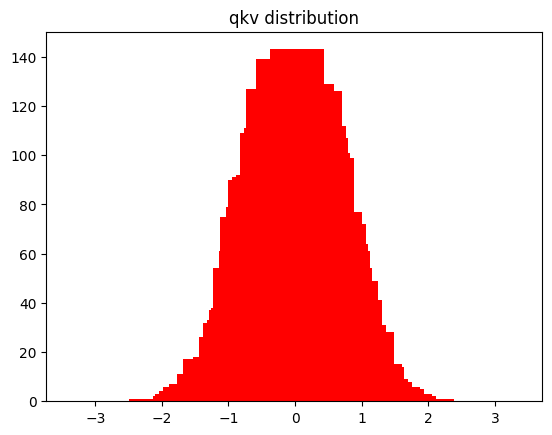

In [16]:
import matplotlib.pyplot as plt 
y_val=torch.histc(qkv,bins=200,min=-3,max=3)
x_val=np.arange(-1,1,0.01)*3#np.arange(-1, 1, 0.01) function call generates an array of numbers starting from -1 up to, but not including, 1, with a step size of 0.01
plt.bar(x_val,y_val,align='center',color=['red'])
plt.title("qkv distribution")

In [20]:
num_heads=8
head_dim=d_model//num_heads #floor division 
qkv=qkv.reshape(batch_size,sequence_length,num_heads,3*head_dim)#The reshaping reorganizes the data so that the third dimension now separates the different heads.

In [22]:
qkv=qkv.permute(0,2,1,3)


In [23]:
qkv.shape

torch.Size([1, 8, 4, 192])

In [33]:
# Getting query key value by breaking the last dimension
q,k,v=qkv.chunk(3,dim=-1)# last dimension that is 192
print(q.shape)
print(k.shape)
print(v.shape)
3 

torch.Size([1, 8, 4, 64])
torch.Size([1, 8, 4, 64])
torch.Size([1, 8, 4, 64])


In [ ]:
#Self Attention for Multi heads


##### For a single Head
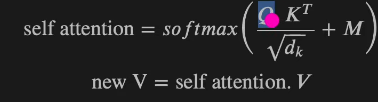

In [38]:
# self attention 
d_k=q.size()[-1]
scaled=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)# -2,-1 is the dimension which we want to transpose because we can transpose for tensor directly like numpy
scaled.shape

torch.Size([1, 8, 4, 4])

In [56]:
mask=torch.full(scaled.size(),float('-inf'))# it wil create a size of scaled with all the value infinity
mask=torch.triu(mask,diagonal=1)# triangular upper. it will get the  upper triangular and lower triangular to 0

In [64]:
# we are doing negative infinity because we perform softmax and there we perform exponentialexponential of -inf is 0.

In [57]:
mask.size()# 1 batch 8 head and 4*4 matrices

torch.Size([1, 8, 4, 4])

In [58]:
# mask for single head
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [63]:
# for 1 head
(scaled+mask)[0][1]

tensor([[-0.1965,    -inf,    -inf,    -inf],
        [-0.0822,  0.2205,    -inf,    -inf],
        [-0.1462, -0.0753,  0.3507,    -inf],
        [ 0.0684,  0.7293, -0.4478, -0.4641]], grad_fn=<SelectBackward0>)

In [65]:
scaled+=mask

In [68]:
attention=F.softmax(scaled,dim=1)

In [69]:
attention.shape

torch.Size([1, 8, 4, 4])

In [70]:
attention[0]

tensor([[[0.1105,    nan,    nan,    nan],
         [0.1096, 0.1169,    nan,    nan],
         [0.0685, 0.1507, 0.1260,    nan],
         [0.1418, 0.0960, 0.1739, 0.0896]],

        [[0.0943,    nan,    nan,    nan],
         [0.1061, 0.1172,    nan,    nan],
         [0.1064, 0.1169, 0.1305,    nan],
         [0.1266, 0.2218, 0.0736, 0.0859]],

        [[0.1464,    nan,    nan,    nan],
         [0.1234, 0.1298,    nan,    nan],
         [0.2074, 0.0478, 0.1997,    nan],
         [0.1162, 0.0894, 0.1379, 0.1734]],

        [[0.0710,    nan,    nan,    nan],
         [0.1969, 0.1239,    nan,    nan],
         [0.1503, 0.1126, 0.1322,    nan],
         [0.1120, 0.0966, 0.1601, 0.1396]],

        [[0.1248,    nan,    nan,    nan],
         [0.1524, 0.1048,    nan,    nan],
         [0.0983, 0.2037, 0.0671,    nan],
         [0.0996, 0.1127, 0.0700, 0.1299]],

        [[0.2084,    nan,    nan,    nan],
         [0.1154, 0.0905,    nan,    nan],
         [0.1637, 0.1411, 0.0725,    nan],
 

In [74]:
values=torch.matmul(attention,v)
values.shape# 1 for batch 8 for head 4 for sequence and 464 dimensional vector 64*8 heads =512 dimension

torch.Size([1, 8, 4, 64])

In [75]:
import math
def scaled_dot_product(q,k,v,mask=None):
    d_k=q.size(-1)
    scaled=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
    if mask is not None:
        scaled+=mask
    attention=F.softmax(scaled,dim=-1)
    out=torch.matmul(attention,v)
    return out,attention


In [86]:
values,attention=scaled_dot_product(q,k,v,mask=mask)

In [87]:
values.size(),attention.size()

(torch.Size([1, 8, 4, 64]), torch.Size([1, 8, 4, 4]))

In [88]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4333, 0.5667, 0.0000, 0.0000],
        [0.1781, 0.3830, 0.4390, 0.0000],
        [0.2814, 0.2106, 0.3540, 0.1540]], grad_fn=<SelectBackward0>)

In [89]:
# now we are going to combine all of our head together  to 512 dimension which is exactly the input dimension
values=values.reshape(batch_size,sequence_length,num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [90]:
# here head can transform the share the information that they have learned with each other they are transform to linear layer
linear_layer=nn.Linear(d_model,d_model)# Feed forward
out=linear_layer(values)

In [91]:
out.shape

torch.Size([1, 4, 512])

### Implementing all above in single

In [109]:
import torch
import torch.nn as nn
import math 

def scaled_dot_product(q,k,v,mask=None):
    d_k=q.size(-1)
    scaled=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
    if mask is not None:
        scaled+=mask
    attention=F.softmax(scaled,dim=-1)
    out=torch.matmul(attention,v)
    return out,attention

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim,d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.input_dim=input_dim
        self.d_model=d_model
        self.num_heads=num_heads
        self.head_dim=d_model//num_heads
        self.qkv_layer=nn.Linear(input_dim, 3*d_model)
        self.linear_layer=nn.Linear(d_model, d_model)
    def forward(self,x,mask=None):
        batch_size,sequence_length ,input_dim=x.size()
        print(f'x.size(),{x.size()}')
        qkv=self.qkv_layer(x)
        print(f"qkv.size(),{qkv.size()}")
        qkv=qkv.reshape(batch_size, sequence_length,self.num_heads,3*self.head_dim)
        print(f"qkv.size(),{qkv.size()}")

        qkv=qkv.permute(0,2,1,3)
        print(f"qkv.size(): {qkv.size()}")
        q,k,v=qkv.chunk(3,dim=-1)
        print(f"q.size(): {q.size()}, k.size(): {k.size()}, v.size(): {v.size()}")
        values,attention=scaled_dot_product(q,k,v,mask)
        print(f"values.size(): {values.size()}, attention.size(): {attention.size()}")
        values=values.reshape(batch_size,sequence_length,self.num_heads*self.head_dim)
        print(f"values.size(): {values.size()}")
        out=self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out




In [110]:
input_dim=1024
d_model=512
num_heads=8
batch_size=30
sequence_length=5
x=torch.randn(batch_size, sequence_length,input_dim)
model=MultiHeadAttention(input_dim,d_model,num_heads)
out=model.forward(x)

x.size(),torch.Size([30, 5, 1024])
qkv.size(),torch.Size([30, 5, 1536])
qkv.size(),torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q.size(): torch.Size([30, 8, 5, 64]), k.size(): torch.Size([30, 8, 5, 64]), v.size(): torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64]), attention.size(): torch.Size([30, 8, 5, 5])
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


In [111]:
# input batch of 30 ,5 words in a sentence , each of them is 1024
# all heads are combined to generate 1536  dimensions 
# they are broken into 8 attention heads
# They are swapped 
#  the query key value is breakes
# attention value metrices for every single attention head 
# concatenate as a value
# Send to forward which share information 
